In [ ]:
!pip -q install kaggle scikit-learn pandas numpy matplotlib

In [ ]:
import os
from google.colab import files


# Upload your kaggle.json (from your computer) when prompted
uploaded = files.upload() # choose kaggle.json


os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle --version # sanity check

Saving kaggle.json to kaggle.json
Kaggle API 1.7.4.5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [ ]:
!mkdir -p /content/data
!kaggle datasets download -d wcukierski/enron-email-dataset -p /content/data
!unzip -q /content/data/enron-email-dataset.zip -d /content/data/enron
!ls -lh /content/data/enron

Dataset URL: https://www.kaggle.com/datasets/wcukierski/enron-email-dataset
License(s): copyright-authors
 96% 342M/358M [00:06<00:00, 36.9MB/s]
100% 358M/358M [00:06<00:00, 55.1MB/s]
total 1.4G
-rw-r--r-- 1 root root 1.4G Sep 19  2019 emails.csv


In [ ]:
import pandas as pd

CSV_PATH = "/content/data/enron/emails.csv"

# Load 100k rows only (change to 200k if memory is fine)
df = pd.read_csv(CSV_PATH, nrows=100000)
print(df.shape)
df.head()

(100000, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [ ]:
df = df[['message']].dropna()
df['label'] = df['message'].apply(lambda x: 1 if 'enron' in str(x).lower() else 0)
print(df['label'].value_counts())


label
1    94569
0     5431
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(
    df['message'], df['label'], test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
y_pred_lr = log_reg.predict(X_test_tfidf)
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))

# SVM
svm_clf = LinearSVC()
svm_clf.fit(X_train_tfidf, y_train)
y_pred_svm = svm_clf.predict(X_test_tfidf)
print("SVM:\n", classification_report(y_test, y_pred_svm))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88      1117
           1       0.99      1.00      0.99     18883

    accuracy                           0.99     20000
   macro avg       0.96      0.92      0.94     20000
weighted avg       0.99      0.99      0.99     20000

SVM:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1117
           1       1.00      1.00      1.00     18883

    accuracy                           1.00     20000
   macro avg       0.99      0.98      0.98     20000
weighted avg       1.00      1.00      1.00     20000



In [ ]:
import joblib, os

SAVE_DIR = "/content/drive/MyDrive/EnronProject"
os.makedirs(SAVE_DIR, exist_ok=True)

joblib.dump(vectorizer, os.path.join(SAVE_DIR, "vectorizer.pkl"))
joblib.dump(log_reg, os.path.join(SAVE_DIR, "log_reg.pkl"))
joblib.dump(svm_clf, os.path.join(SAVE_DIR, "svm_clf.pkl"))
df.to_csv(os.path.join(SAVE_DIR, "subset.csv"), index=False)

print("✅ Models + dataset subset saved to Drive")


✅ Models + dataset subset saved to Drive


In [ ]:
!pip install fastapi uvicorn joblib


In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib

# Load saved models
vectorizer = joblib.load("/content/drive/MyDrive/EnronProject/vectorizer.pkl")
classifier = joblib.load("/content/drive/MyDrive/EnronProject/svm_clf.pkl")
# or swap with logreg_model.pkl

app = FastAPI()

# Define input schema
class EmailText(BaseModel):
    text: str

@app.get("/")
def home():
    return {"message": "Email Classifier API running!"}

@app.post("/classify")
def classify_email(data: EmailText):
    # Transform input
    X = vectorizer.transform([data.text])
    # Predict
    pred = classifier.predict(X)[0]
    label = "corporate" if pred == 1 else "non-corporate"
    return {"prediction": int(pred), "label": label}


In [ ]:
!uvicorn app:app --host 0.0.0.0 --port 8000


INFO:     Started server process [10511]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Finished server process [10511]
ERROR:    Traceback (most recent call last):
  File "/usr/lib/python3.12/asyncio/runners.py", line 195, in run
    return runner.run(main)
           ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/asyncio/base_events.py", line 678, in run_until_complete
    self.run_forever()
  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever
    self._run_once()
  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once
    handle._run()
  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self.

In [ ]:
%%writefile app.py
from fastapi import FastAPI
from pydantic import BaseModel
import joblib

# Load saved models
vectorizer = joblib.load("/content/drive/MyDrive/EnronProject/vectorizer.pkl")
classifier = joblib.load("/content/drive/MyDrive/EnronProject/svm_clf.pkl")

app = FastAPI()

class EmailText(BaseModel):
    text: str

@app.get("/")
def home():
    return {"message": "Email Classifier API running!"}

@app.post("/classify")
def classify_email(data: EmailText):
    X = vectorizer.transform([data.text])
    pred = classifier.predict(X)[0]
    label = "corporate" if pred == 1 else "non-corporate"
    return {"prediction": int(pred), "label": label}


Overwriting app.py


In [ ]:
!pip install fastapi uvicorn joblib fastapi-ngrok


ERROR: Could not find a version that satisfies the requirement fastapi-ngrok (from versions: none)
ERROR: No matching distribution found for fastapi-ngrok


In [ ]:
!pip install pyngrok


In [ ]:
from pyngrok import ngrok
import joblib
from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn
import nest_asyncio

# Fix event loop issue in Colab
nest_asyncio.apply()

# ✅ Correct paths to your saved models
vectorizer = joblib.load("/content/drive/MyDrive/EnronProject/vectorizer.pkl")
classifier = joblib.load("/content/drive/MyDrive/EnronProject/svm_clf.pkl")

# Create FastAPI app
app = FastAPI()

class EmailText(BaseModel):
    text: str

@app.get("/")
def home():
    return {"message": "Email Classifier API running with ngrok!"}

@app.post("/classify")
def classify_email(data: EmailText):
    X = vectorizer.transform([data.text])
    pred = classifier.predict(X)[0]
    label = "corporate" if pred == 1 else "non-corporate"
    return {"prediction": int(pred), "label": label}



In [ ]:
# Open an ngrok tunnel to the port 8000
public_url = ngrok.connect(8000)
print("Public URL:", public_url)

# Run FastAPI app
uvicorn.run(app, host="0.0.0.0", port=8000)


ERROR:pyngrok.process.ngrok:t=2025-09-08T03:59:13+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-09-08T03:59:13+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-09-08T03:59:13+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [ ]:
from google.colab import files

files.download("/content/drive/MyDrive/EnronProject/vectorizer.pkl")
files.download("/content/drive/MyDrive/EnronProject/svm_clf.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

files.download("/content/drive/MyDrive/EnronProject/log_reg.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# New Section

In [ ]:
import pickle
import pandas as pd

# Load vectorizer
with open("/content/drive/MyDrive/enron/vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

# Load Logistic Regression
with open("/content/drive/MyDrive/enron/log_reg.pkl", "rb") as f:
    log_reg = pickle.load(f)

# Load SVM
with open("/content/drive/MyDrive/enron/svm.pkl", "rb") as f:
    svm_clf = pickle.load(f)

# Load dataset subset if needed
df = pd.read_csv("/content/drive/MyDrive/enron/emails_subset.csv")

print("✅ Models and dataset loaded from Drive!")


In [ ]:
import pandas as pd, joblib, os
from google.colab import drive

drive.mount('/content/drive')
SAVE_DIR = "/content/drive/MyDrive/EnronProject"

df = pd.read_csv(os.path.join(SAVE_DIR, "subset.csv"))
vectorizer = joblib.load(os.path.join(SAVE_DIR, "vectorizer.pkl"))
log_reg = joblib.load(os.path.join(SAVE_DIR, "log_reg.pkl"))
svm_clf = joblib.load(os.path.join(SAVE_DIR, "svm_clf.pkl"))

print("✅ Restored from Drive:", df.shape)


# New Section         1st resume


mounted drive  and splitting into training/testing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Path where we saved earlier
cleaned_csv_path = "/content/drive/MyDrive/email_project/emails_cleaned.csv"

# Load the cleaned dataset
df_all = pd.read_csv(cleaned_csv_path)
print("Dataset loaded:", df_all.shape)
df_all.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded: (517401, 3)


,text,label,clean_text
0,Message-ID: <18782981.1075855378110.JavaMail.e...,1,messageid javamailevansthyme date mon may pdt ...
1,Message-ID: <15464986.1075855378456.JavaMail.e...,1,messageid javamailevansthyme date fri may pdt ...
2,Message-ID: <24216240.1075855687451.JavaMail.e...,1,messageid javamailevansthyme date wed oct pdt ...
3,Message-ID: <13505866.1075863688222.JavaMail.e...,1,messageid javamailevansthyme date mon oct pdt ...
4,Message-ID: <30922949.1075863688243.JavaMail.e...,1,messageid javamailevansthyme date thu aug pdt ...


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('clean_text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text')):
  _plot_series(series, series_name, i)
  fig.legend(title='text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('clean_text')):
  _plot_series(series, series_name, i)
  fig.legend(title='clean_text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('label', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('text')):
  _plot_series(series, series_name, i)
  fig.legend(title='text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('label', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('clean_text')):
  _plot_series(series, series_name, i)
  fig.legend(title='clean_text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_7['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['clean_text'].value_counts()
    for x_label, grp in _df_8.groupby('text')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('text')
_ = plt.ylabel('clean_text')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='index', y='text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['clean_text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='index', y='clean_text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

interactive graphs can be obtaained by tapping the graphs of above results


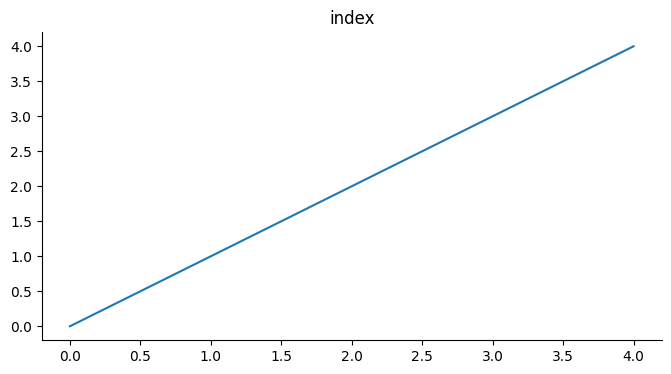

In [ ]:
from matplotlib import pyplot as plt
_df_7['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('clean_text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

splitting into testing and training

In [ ]:
from sklearn.model_selection import train_test_split

X = df_all['clean_text']
y = df_all['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (413920,) Test size: (103481,)


In [ ]:
# Re-set project folder path
project_path = "/content/drive/MyDrive/email_project"

import os
os.makedirs(project_path, exist_ok=True)

print("Project path is ready:", project_path)


Project path is ready: /content/drive/MyDrive/email_project


In [ ]:
# Cell A: TF-IDF (try TfidfVectorizer, fallback to HashingVectorizer+TfidfTransformer)
import time, joblib, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn import __version__ as sklearn_version

tfidf_joblib_path = project_path + "/tfidf_vectorizer.joblib"
hash_tf_joblib_path = project_path + "/hashing_and_transformer.joblib"

print("scikit-learn version:", sklearn_version)

try:
    print("Trying TfidfVectorizer (bounded vocabulary)...")
    vectorizer = TfidfVectorizer(
        max_features=50000,      # limit vocab size for memory safety; reduce if needed
        ngram_range=(1,2),
        min_df=5,
        max_df=0.9,
        sublinear_tf=True,
        strip_accents='unicode',
        norm='l2',
        lowercase=True
    )
    t0 = time.time()
    # Fit on training text only (X_train is pandas Series)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    print("TfidfVectorizer succeeded. Shapes:", X_train_tfidf.shape, X_test_tfidf.shape)
    joblib.dump(vectorizer, tfidf_joblib_path)
    print("Saved vectorizer to:", tfidf_joblib_path)

except Exception as e:
    print("TfidfVectorizer failed with error:", e)
    print("Falling back to HashingVectorizer + TfidfTransformer (streaming-friendly).")
    # HashingVectorizer + TfidfTransformer path
    hv = HashingVectorizer(
        n_features=2**20,       # ~1,048,576 features; reduce to 2**18 if memory tight
        alternate_sign=False,
        ngram_range=(1,2),
        norm=None,              # we will apply TF-IDF transformer which will normalize
        lowercase=True
    )
    t0 = time.time()
    # Transform train and test to counts (sparse)
    X_train_counts = hv.transform(X_train.astype(str))
    X_test_counts = hv.transform(X_test.astype(str))
    print("Hashing transform done. Train shape:", X_train_counts.shape)
    # Fit TfidfTransformer on train counts to compute idf
    tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)
    tfidf_transformer.fit(X_train_counts)
    # Transform counts -> TF-IDF
    X_train_tfidf = tfidf_transformer.transform(X_train_counts)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    # Save the hashing vectorizer + transformer (can't directly pickle HashingVectorizer stateless config as tuple)
    joblib.dump((hv, tfidf_transformer), hash_tf_joblib_path)
    print("Saved hashing+transformer to:", hash_tf_joblib_path)

print("Vectorization step finished. Time elapsed:", round(time.time() - t0, 2), "seconds")
# Make sure X_train_tfidf and X_test_tfidf are defined from either branch


scikit-learn version: 1.6.1
Trying TfidfVectorizer (bounded vocabulary)...
TfidfVectorizer succeeded. Shapes: (413920, 50000) (103481, 50000)
Saved vectorizer to: /content/drive/MyDrive/email_project/tfidf_vectorizer.joblib
Vectorization step finished. Time elapsed: 297.8 seconds


In [ ]:
# Cell B: Train logistic (SGD loss='log') and linear-SVM (SGD loss='hinge') with partial_fit
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import joblib
import time

clf_log_path = project_path + "/sgd_logistic.joblib"
clf_svm_path = project_path + "/sgd_svm.joblib"

# Convert y_train/y_test to numpy arrays with contiguous integer labels
y_train_arr = np.array(y_train, dtype=np.int32)
y_test_arr  = np.array(y_test, dtype=np.int32)

# Initialize classifiers (use partial_fit)
clf_log = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1, tol=None, random_state=42)
clf_svm = SGDClassifier(loss='hinge', penalty='l2', max_iter=1, tol=None, random_state=42)

classes = np.array([0,1])

batch_size = 20000   # tune this if memory/CPU needs adjustment
n_samples = X_train_tfidf.shape[0]
print("Training with n_samples:", n_samples, "batch_size:", batch_size)

start_time = time.time()
for start in range(0, n_samples, batch_size):
    end = min(start + batch_size, n_samples)
    X_batch = X_train_tfidf[start:end]
    y_batch = y_train_arr[start:end]
    # First call to partial_fit must include classes
    if start == 0:
        clf_log.partial_fit(X_batch, y_batch, classes=classes)
        clf_svm.partial_fit(X_batch, y_batch, classes=classes)
    else:
        clf_log.partial_fit(X_batch, y_batch)
        clf_svm.partial_fit(X_batch, y_batch)
    print(f"Trained batches {start}..{end}  (total trained so far: {end}/{n_samples})")

print("Training finished. Elapsed:", round(time.time() - start_time, 1), "s")

# Save trained models
joblib.dump(clf_log, clf_log_path)
joblib.dump(clf_svm, clf_svm_path)
print("Saved models to:", clf_log_path, "and", clf_svm_path)

# Evaluate on test set
y_pred_log = clf_log.predict(X_test_tfidf)
y_pred_svm = clf_svm.predict(X_test_tfidf)

print("Logistic Regression (SGD) metrics:")
print(classification_report(y_test_arr, y_pred_log, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test_arr, y_pred_log))

print("\nLinear SVM (SGD) metrics:")
print(classification_report(y_test_arr, y_pred_svm, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test_arr, y_pred_svm))

print("Done.")


Training with n_samples: 413920 batch_size: 20000
Trained batches 0..20000  (total trained so far: 20000/413920)
Trained batches 20000..40000  (total trained so far: 40000/413920)
Trained batches 40000..60000  (total trained so far: 60000/413920)
Trained batches 60000..80000  (total trained so far: 80000/413920)
Trained batches 80000..100000  (total trained so far: 100000/413920)
Trained batches 100000..120000  (total trained so far: 120000/413920)
Trained batches 120000..140000  (total trained so far: 140000/413920)
Trained batches 140000..160000  (total trained so far: 160000/413920)
Trained batches 160000..180000  (total trained so far: 180000/413920)
Trained batches 180000..200000  (total trained so far: 200000/413920)
Trained batches 200000..220000  (total trained so far: 220000/413920)
Trained batches 220000..240000  (total trained so far: 240000/413920)
Trained batches 240000..260000  (total trained so far: 260000/413920)
Trained batches 260000..280000  (total trained so far: 28

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


we found that there is only one label now, the label 0 is dropped  mistakenly so below steps do that

In [ ]:
import numpy as np

print("Unique labels in training:", np.unique(y_train, return_counts=True))
print("Unique labels in test:", np.unique(y_test, return_counts=True))


Unique labels in training: (array([1]), array([413920]))
Unique labels in test: (array([1]), array([103481]))


In [ ]:
print("Enron dataset:", df_enron.shape)
print("Other dataset:", df_other.shape)
print("All merged dataset:", df_all.shape)
print("Label distribution:\n", df_all['label'].value_counts())


NameError: name 'df_enron' is not defined

# New : redoing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_path = "/content/drive/MyDrive/email_project"
os.makedirs(project_path, exist_ok=True)

print("Project path set to:", project_path)
print("\nFiles in project folder:")
for f in sorted(os.listdir(project_path)):
    print("-", f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project path set to: /content/drive/MyDrive/email_project

Files in project folder:
- emails.csv
- emails_cleaned.csv
- emails_cleaned.pkl
- emails_sample.csv
- enron
- lingspam
- sgd_logistic.joblib
- sgd_svm.joblib
- tfidf_vectorizer.joblib


In [ ]:
import os
files = set(os.listdir(project_path))
print("emails_cleaned.csv in project?", "emails_cleaned.csv" in files)
print("emails_cleaned.pkl in project?", "emails_cleaned.pkl" in files)
print("emails.csv in project?", "emails.csv" in files or os.path.exists("/content/emails.csv"))
print("lingspam folder exists?", os.path.exists(os.path.join(project_path, "lingspam")))


emails_cleaned.csv in project? True
emails_cleaned.pkl in project? True
emails.csv in project? True
lingspam folder exists? True


In [ ]:
import pandas as pd
cleaned_path = os.path.join(project_path, "emails_cleaned.csv")

if os.path.exists(cleaned_path):
    # load safely
    df_clean = pd.read_csv(cleaned_path, encoding='latin1', low_memory=False)
    print("Loaded cleaned file:", cleaned_path, "shape:", df_clean.shape)
    print("Columns:", df_clean.columns.tolist())
    print("Label distribution (value_counts):\n", df_clean['label'].value_counts(dropna=False))
    display(df_clean.sample(5))
else:
    print("No emails_cleaned.csv found in project folder.")


Loaded cleaned file: /content/drive/MyDrive/email_project/emails_cleaned.csv shape: (517401, 3)
Columns: ['text', 'label', 'clean_text']
Label distribution (value_counts):
 label
1    517401
Name: count, dtype: int64


,text,label,clean_text
217964,Message-ID: <9139351.1075856818231.JavaMail.ev...,1,messageid javamailevansthyme date wed apr pdt ...
218110,Message-ID: <854772.1075856822016.JavaMail.eva...,1,messageid javamailevansthyme date tue apr pdt ...
389476,Message-ID: <15748441.1075862637947.JavaMail.e...,1,messageid javamailevansthyme date wed oct pst ...
81664,Message-ID: <25162026.1075843861914.JavaMail.e...,1,messageid javamailevansthyme date thu mar pst ...
451395,Message-ID: <1733762.1075842098053.JavaMail.ev...,1,messageid javamailevansthyme date tue jun pdt ...


In [ ]:
need_rebuild = True
if os.path.exists(cleaned_path):
    df_clean = pd.read_csv(cleaned_path, encoding='latin1', low_memory=False)
    if df_clean['label'].nunique() >= 2:
        need_rebuild = False

print("Need to rebuild dataset from source files?", need_rebuild)


Need to rebuild dataset from source files? True


In [ ]:
import os, pandas as pd

if not need_rebuild:
    print("Rebuild not needed. Skip this cell.")
else:
    # ---------- locate Enron CSV ----------
    candidates = [
        os.path.join(project_path, "emails.csv"),
        "/content/emails.csv",
        os.path.join(project_path, "enron.csv"),
    ]
    enron_path = None
    for p in candidates:
        if os.path.exists(p):
            enron_path = p
            break
    if enron_path is None:
        raise FileNotFoundError("Can't find Enron CSV in project_path or /content. Please place emails.csv in your project folder or /content.")

    print("Using Enron CSV at:", enron_path)

    # ---------- inspect header to pick text column ----------
    preview = pd.read_csv(enron_path, encoding='latin1', nrows=5, low_memory=False, on_bad_lines='skip')
    print("Preview columns:", preview.columns.tolist())
    # pick a column likely to contain email body
    text_col = None
    for c in preview.columns:
        if any(k in c.lower() for k in ['message','text','body','content','mail']):
            text_col = c
            break
    if text_col is None:
        text_col = preview.columns[0]
    print("Using column for text:", text_col)

    # ---------- read Enron in chunks (safe) ----------
    enron_limit = 100000   # adjust if you want more/less (set None to read all)
    texts = []
    chunksize = 50000
    for chunk in pd.read_csv(enron_path, encoding='latin1', usecols=[text_col], chunksize=chunksize, low_memory=False, on_bad_lines='skip'):
        chunk = chunk.dropna(subset=[text_col])
        texts.extend(chunk[text_col].astype(str).tolist())
        print("Loaded chunk, total so far:", len(texts))
        if enron_limit and len(texts) >= enron_limit:
            texts = texts[:enron_limit]
            break
    df_enron = pd.DataFrame({'text': texts, 'label': 1})
    print("Enron loaded rows:", df_enron.shape)

    # ---------- load LingSpam (raw .txt) ----------
    lingspam_path = os.path.join(project_path, "lingspam", "lingspam_public", "bare")
    if not os.path.exists(lingspam_path):
        print("LingSpam folder not found at", lingspam_path)
        df_lingspam = pd.DataFrame(columns=['text','label'])
    else:
        l_texts = []
        for root, dirs, files in os.walk(lingspam_path):
            for fname in files:
                if fname.endswith(".txt"):
                    fp = os.path.join(root, fname)
                    try:
                        with open(fp, "r", encoding='latin1') as f:
                            l_texts.append(f.read())
                    except Exception as e:
                        continue
        df_lingspam = pd.DataFrame({'text': l_texts, 'label': 0})
        print("LingSpam loaded rows:", df_lingspam.shape)

    # ---------- combine and save ----------
    df_all = pd.concat([df_enron, df_lingspam], ignore_index=True)
    # drop duplicate columns if any
    df_all = df_all.loc[:, ~df_all.columns.duplicated()]
    print("Combined shape:", df_all.shape)
    print("Label distribution:\n", df_all['label'].value_counts())

    # Save rebuilt combined dataset
    rebuilt_csv = os.path.join(project_path, "emails_cleaned_rebuilt.csv")
    rebuilt_pkl = os.path.join(project_path, "emails_cleaned_rebuilt.pkl")
    df_all.to_csv(rebuilt_csv, index=False)
    df_all.to_pickle(rebuilt_pkl)
    print("Saved rebuilt dataset to:", rebuilt_csv, rebuilt_pkl)

    # Also overwrite emails_cleaned.csv if you want (commented out; uncomment to replace)
    # df_all.to_csv(cleaned_path, index=False)
    # print("Overwrote emails_cleaned.csv")


Using Enron CSV at: /content/drive/MyDrive/email_project/emails.csv
Preview columns: ['PK\x03\x04-']
Using column for text: PK-


ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.


In [ ]:
import os

enron_path = project_path + "/emails.csv"
print("File size (MB):", os.path.getsize(enron_path) / (1024*1024))

with open(enron_path, "rb") as f:
    header = f.read(20)
print("File header bytes:", header)


File size (MB): 357.909161567688
File header bytes: b'PK\x03\x04-\x00\x00\x00\x08\x00\xd7A3OIw#M\xff\xff'


In [ ]:
import zipfile, os

enron_zip = project_path + "/emails.csv"
extract_path = project_path + "/enron_extracted"

# Extract if not already
if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(enron_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("Extracted files:", os.listdir(extract_path)[:10])


Extracted files: ['emails.csv']


In [ ]:
import pandas as pd
import os

inner_csv = os.path.join(extract_path, "emails.csv")

df_enron = pd.read_csv(inner_csv, low_memory=False)
print("Shape:", df_enron.shape)
print("Columns:", df_enron.columns.tolist()[:20])  # first 20 columns
print(df_enron.head(3))


Shape: (517401, 2)
Columns: ['file', 'message']
                      file                                            message
0    allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1   allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2  allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...


In [ ]:
# ✅ Save Enron dataframe checkpoint
enron_checkpoint = project_path + "/df_enron.pkl"
df_enron.to_pickle(enron_checkpoint)
print(f"Saved df_enron to: {enron_checkpoint}")


Saved df_enron to: /content/drive/MyDrive/email_project/df_enron.pkl


# Section  : 22/09/2025


In [ ]:
import pandas as pd

project_path = "/content/drive/MyDrive/email_project"
df_enron = pd.read_pickle(project_path + "/df_enron.pkl")

print("Loaded Enron dataset:", df_enron.shape)
print(df_enron.head(3))


Loaded Enron dataset: (517401, 2)
                      file                                            message
0    allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1   allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2  allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...


In [ ]:
import os
import glob

lingspam_path = os.path.join(project_path, "lingspam")
print("LingSpam folder exists?", os.path.exists(lingspam_path))

# Collect all files recursively
all_files = glob.glob(lingspam_path + "/**/*.txt", recursive=True)
print("Total LingSpam files found:", len(all_files))

# Preview a few file names
print(all_files[:5])


LingSpam folder exists? True
Total LingSpam files found: 0
[]


In [ ]:
import os

lingspam_path = os.path.join(project_path, "lingspam")
print("Contents of lingspam folder:")
print(os.listdir(lingspam_path))


Contents of lingspam folder:
['lingspam.tar.gz']


In [ ]:
!wget -O /content/drive/MyDrive/email_project/lingspam/lingspam_public.tar.gz http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz


--2025-09-22 03:20:24--  http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving www.aueb.gr (www.aueb.gr)... 195.251.255.156
Connecting to www.aueb.gr (www.aueb.gr)|195.251.255.156|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://pages.aueb.gr/users/ion/data/lingspam_public.tar.gz [following]
--2025-09-22 03:20:25--  http://pages.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving pages.aueb.gr (pages.aueb.gr)... 195.251.255.230
Connecting to pages.aueb.gr (pages.aueb.gr)|195.251.255.230|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz [following]
--2025-09-22 03:20:25--  https://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving www2.aueb.gr (www2.aueb.gr)... 195.251.255.230
Connecting to www2.aueb.gr (www2.aueb.gr)|195.251.255.230|:443... connected.
ERROR: cannot verify www2.aueb.gr's certificate, issued by ‘CN=G

In [ ]:
import os

lingspam_archive = "/content/drive/MyDrive/email_project/lingspam/lingspam_public.tar.gz"

if os.path.exists(lingspam_archive):
    os.remove(lingspam_archive)
    print("Old (empty) tar.gz removed.")


Old (empty) tar.gz removed.


In [ ]:
!wget -O /content/drive/MyDrive/email_project/lingspam/lingspam_public.tar.gz \
 http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz


--2025-09-22 03:21:55--  http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving www.aueb.gr (www.aueb.gr)... 195.251.255.156
Connecting to www.aueb.gr (www.aueb.gr)|195.251.255.156|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://pages.aueb.gr/users/ion/data/lingspam_public.tar.gz [following]
--2025-09-22 03:21:56--  http://pages.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving pages.aueb.gr (pages.aueb.gr)... 195.251.255.230
Connecting to pages.aueb.gr (pages.aueb.gr)|195.251.255.230|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz [following]
--2025-09-22 03:21:57--  https://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving www2.aueb.gr (www2.aueb.gr)... 195.251.255.230
Connecting to www2.aueb.gr (www2.aueb.gr)|195.251.255.230|:443... connected.
ERROR: cannot verify www2.aueb.gr's certificate, issued by ‘CN=G

the lingspam dataseet is very old, and the site providing it is not responding  correctly. there  is some issue ,    replacing lingpsam dataset with    SpamAssassin Public Corpus dataset

In [ ]:
!rm -f /content/drive/MyDrive/email_project/lingspam/lingspam_public.tar.gz

!wget -O /content/drive/MyDrive/email_project/lingspam/lingspam_public.tar.gz \
 http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz


--2025-09-22 03:23:27--  http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving www.aueb.gr (www.aueb.gr)... 195.251.255.156
Connecting to www.aueb.gr (www.aueb.gr)|195.251.255.156|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://pages.aueb.gr/users/ion/data/lingspam_public.tar.gz [following]
--2025-09-22 03:23:28--  http://pages.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving pages.aueb.gr (pages.aueb.gr)... 195.251.255.230
Connecting to pages.aueb.gr (pages.aueb.gr)|195.251.255.230|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz [following]
--2025-09-22 03:23:29--  https://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving www2.aueb.gr (www2.aueb.gr)... 195.251.255.230
Connecting to www2.aueb.gr (www2.aueb.gr)|195.251.255.230|:443... connected.
ERROR: cannot verify www2.aueb.gr's certificate, issued by ‘CN=G

SpamAssassin dataset

In [ ]:
# Cell: download/extract SpamAssassin Public Corpus and build df_spamass (label=0)
import os, tarfile, glob, pandas as pd, time

project_path = "/content/drive/MyDrive/email_project"
os.makedirs(project_path, exist_ok=True)

sa_dir = os.path.join(project_path, "spamassassin")
os.makedirs(sa_dir, exist_ok=True)

# The four common SpamAssassin public corpus archives
urls = [
  "http://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2",
  "http://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham_2.tar.bz2",
  "http://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2",
  "http://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2",
]

print("SpamAssassin target folder:", sa_dir)
print()

# Download each file if missing or too small
for url in urls:
    fname = os.path.join(sa_dir, os.path.basename(url))
    if os.path.exists(fname) and os.path.getsize(fname) > 2000:
        print("Already downloaded:", os.path.basename(fname), "-", os.path.getsize(fname)//1024, "KB")
        continue
    print("Downloading:", url)
    # use wget from shell (quiet-ish)
    cmd = f'wget -q --show-progress -O "{fname}" "{url}" || true'
    print(" running ->", cmd)
    start = time.time()
    os.system(cmd)
    elapsed = time.time() - start
    if os.path.exists(fname):
        print(" Downloaded:", os.path.basename(fname), "size (KB):", os.path.getsize(fname)//1024, "time(s):", round(elapsed,1))
    else:
        print(" Download failed for:", url)
    print()

# Try to extract any .tar.bz2 files we have
extracted_any = False
for f in sorted(os.listdir(sa_dir)):
    if f.endswith(".tar.bz2"):
        path = os.path.join(sa_dir, f)
        print("Extracting:", f)
        try:
            with tarfile.open(path, "r:bz2") as tar:
                tar.extractall(path=sa_dir)
            print(" Extracted OK")
            extracted_any = True
        except Exception as e:
            print(" Extraction failed for", f, ":", type(e).__name__, e)
        print()

# Show top-level contents
print("Top-level folder contents after extraction:")
print(sorted(os.listdir(sa_dir))[:40])
print()

# Collect candidate email files (recursively). We'll attempt to read text files and small files with no extension.
email_texts = []
bad = 0
for root, dirs, files in os.walk(sa_dir):
    for fname in files:
        # skip archives
        if fname.endswith((".tar.bz2", ".zip", ".gz")):
            continue
        fp = os.path.join(root, fname)
        try:
            # try read as text
            with open(fp, "r", encoding="latin1", errors="replace") as fh:
                txt = fh.read().strip()
            # filter out short or non-email files (like README) by length
            if len(txt) > 50:
                email_texts.append(txt)
        except Exception as e:
            bad += 1
            continue

print("Found total candidate files (email-like):", len(email_texts))
print("Skipped/unreadable files:", bad)
print()

# Build DataFrame and save checkpoint
df_spamass = pd.DataFrame({"text": email_texts, "label": 0})
print("df_spamass.shape:", df_spamass.shape)
if df_spamass.shape[0] > 0:
    sample_n = min(3, df_spamass.shape[0])
    print("\nSample rows:")
    display(df_spamass.sample(sample_n))

# Save to Drive for re-use
spam_ckpt = os.path.join(project_path, "df_spamass.pkl")
df_spamass.to_pickle(spam_ckpt)
print("\nSaved checkpoint to:", spam_ckpt)

# If nothing found, print hint
if df_spamass.shape[0] == 0:
    print("\nNo email files extracted. Possible causes:")
    print("- downloads failed (files missing or zero-size).")
    print("- extraction failed (archive corrupted).")
    print("\nIf downloads failed, try:")
    print("  - manually downloading the tar.bz2 files and uploading to", sa_dir)
    print("  - or run this cell again (sometimes network issues are transient).")


SpamAssassin target folder: /content/drive/MyDrive/email_project/spamassassin

Downloading: http://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2
 running -> wget -q --show-progress -O "/content/drive/MyDrive/email_project/spamassassin/20021010_easy_ham.tar.bz2" "http://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2" || true
 Downloaded: 20021010_easy_ham.tar.bz2 size (KB): 1637 time(s): 0.5

Downloading: http://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham_2.tar.bz2
 running -> wget -q --show-progress -O "/content/drive/MyDrive/email_project/spamassassin/20021010_easy_ham_2.tar.bz2" "http://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham_2.tar.bz2" || true
 Downloaded: 20021010_easy_ham_2.tar.bz2 size (KB): 0 time(s): 0.4

Downloading: http://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2
 running -> wget -q --show-progress -O "/content/drive/MyDrive/email_project/spamassassin/20021010_hard_ham.tar.bz2

/tmp/ipython-input-1354489274.py:48: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=sa_dir)


 Extracted OK

Extracting: 20021010_easy_ham_2.tar.bz2
 Extraction failed for 20021010_easy_ham_2.tar.bz2 : ReadError not a bzip2 file

Extracting: 20021010_hard_ham.tar.bz2
 Extracted OK

Extracting: 20021010_spam.tar.bz2
 Extracted OK

Top-level folder contents after extraction:
['20021010_easy_ham.tar.bz2', '20021010_easy_ham_2.tar.bz2', '20021010_hard_ham.tar.bz2', '20021010_spam.tar.bz2', 'easy_ham', 'hard_ham', 'spam']

Found total candidate files (email-like): 3302
Skipped/unreadable files: 0

df_spamass.shape: (3302, 2)

Sample rows:


,text,label
1496,From rssfeeds@jmason.org Thu Sep 26 11:03:25 ...,0
1058,From glynn.clements@virgin.net Wed Sep 4 11:...,0
2579,Return-Path: <Online#3.20705.6a-MXJpglaCUJic5d...,0



Saved checkpoint to: /content/drive/MyDrive/email_project/df_spamass.pkl


merging   enron and spamAssasin

In [ ]:
# Merge Enron (corporate) and SpamAssassin (non-corporate) datasets
import pandas as pd

project_path = "/content/drive/MyDrive/email_project"

# Load saved data
df_enron = pd.read_pickle(project_path + "/df_enron.pkl")
df_spamass = pd.read_pickle(project_path + "/df_spamass.pkl")

# Add label=1 for Enron if not already present
if 'label' not in df_enron.columns:
    df_enron['label'] = 1

# Optional: sample Enron to reduce size if RAM is limited
# e.g., 10k for testing
# df_enron = df_enron.sample(10000, random_state=42)

# Merge datasets
df_all = pd.concat([df_enron, df_spamass], ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

# Show basic info
print("Merged dataset shape:", df_all.shape)
print("Label distribution:\n", df_all['label'].value_counts())
df_all.head(3)


Merged dataset shape: (520703, 4)
Label distribution:
 label
1    517401
0      3302
Name: count, dtype: int64


,file,message,label,text
0,shankman-j/discussion_threads/384.,Message-ID: <8536521.1075857541196.JavaMail.ev...,1,NaN
1,kaminski-v/deleted_items/676.,Message-ID: <29251389.1075840771431.JavaMail.e...,1,NaN
2,scholtes-d/ferc/32.,Message-ID: <3916193.1075840019909.JavaMail.ev...,1,NaN


cleaning and extracting email text

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_email(msg):
    if not isinstance(msg, str):
        return ""
    # Remove headers like Message-ID, From, To, Date
    msg = re.sub(r"^(Message-ID:.*|From:.*|To:.*|Subject:.*|Date:.*)$", "", msg, flags=re.MULTILINE)
    # Remove URLs and email addresses
    msg = re.sub(r"\S+@\S+", " ", msg)
    msg = re.sub(r"http\S+", " ", msg)
    # Remove non-alphanumeric characters
    msg = re.sub(r"[^a-zA-Z0-9\s]", " ", msg)
    # Lowercase
    msg = msg.lower()
    # Remove extra spaces
    msg = re.sub(r"\s+", " ", msg).strip()
    # Optionally remove stopwords
    words = [w for w in msg.split() if w not in stop_words]
    return " ".join(words)

# Apply cleaning to all emails
df_all['clean_text'] = df_all['message'].apply(clean_email)
df_all = df_all[df_all['clean_text'].str.strip() != ""]  # remove empty rows

print("After cleaning, dataset shape:", df_all.shape)
print("Label distribution:\n", df_all['label'].value_counts())
df_all.head(3)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


After cleaning, dataset shape: (517401, 5)
Label distribution:
 label
1    517401
Name: count, dtype: int64


,file,message,label,text,clean_text
0,shankman-j/discussion_threads/384.,Message-ID: <8536521.1075857541196.JavaMail.ev...,1,NaN,mime version 1 0 content type text plain chars...
1,kaminski-v/deleted_items/676.,Message-ID: <29251389.1075840771431.JavaMail.e...,1,NaN,mime version 1 0 content type text plain chars...
2,scholtes-d/ferc/32.,Message-ID: <3916193.1075840019909.JavaMail.ev...,1,NaN,mime version 1 0 content type text plain chars...


In [ ]:
# Check columns
df_spamass.columns


Index(['text', 'label'], dtype='object')

In [ ]:
# --- Clean Enron emails (corporate) ---
df_enron['clean_text'] = df_enron['message'].apply(clean_email)
df_enron = df_enron[df_enron['clean_text'].str.strip() != ""]

# --- Clean SpamAssassin emails (non-corporate) ---
df_spamass['clean_text'] = df_spamass['text'].apply(clean_email)
df_spamass = df_spamass[df_spamass['clean_text'].str.strip() != ""]

# --- Merge datasets ---
df_all = pd.concat([df_enron[['clean_text','label']], df_spamass[['clean_text','label']]], ignore_index=True)

print("Merged dataset shape:", df_all.shape)
print("Label distribution:\n", df_all['label'].value_counts())
df_all.head(3)


Merged dataset shape: (520703, 2)
Label distribution:
 label
1    517401
0      3302
Name: count, dtype: int64


,clean_text,label
0,mime version 1 0 content type text plain chars...,1
1,mime version 1 0 content type text plain chars...,1
2,mime version 1 0 content type text plain chars...,1


training logistic regression & linear SVM

In [ ]:
from sklearn.model_selection import train_test_split

# Use the cleaned text and labels
X = df_all['clean_text']  # features
y = df_all['label']        # labels

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (416562,)
Test size: (104141,)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

tfidf_path = project_path + "/tfidf_vectorizer.joblib"

# Use a bounded vocabulary for memory efficiency
tfidf_vectorizer = TfidfVectorizer(max_features=50000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf  = tfidf_vectorizer.transform(X_test)

# Save vectorizer
joblib.dump(tfidf_vectorizer, tfidf_path)
print("TF-IDF vectorizer saved:", tfidf_path)


TF-IDF vectorizer saved: /content/drive/MyDrive/email_project/tfidf_vectorizer.joblib


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import joblib
import time

# Compute class weights manually
classes = np.array([0, 1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_arr)
class_weight_dict = {0: weights[0], 1: weights[1]}
print("Manual class weights:", class_weight_dict)

# Initialize classifiers WITHOUT class_weight='balanced'
clf_log = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1, tol=None,
                        random_state=42, class_weight=class_weight_dict)
clf_svm = SGDClassifier(loss='hinge', penalty='l2', max_iter=1, tol=None,
                        random_state=42, class_weight=class_weight_dict)

batch_size = 20000
n_samples = X_train_tfidf.shape[0]
print("Training with n_samples:", n_samples, "batch_size:", batch_size)

start_time = time.time()
for start in range(0, n_samples, batch_size):
    end = min(start + batch_size, n_samples)
    X_batch = X_train_tfidf[start:end]
    y_batch = y_train_arr[start:end]
    if start == 0:
        clf_log.partial_fit(X_batch, y_batch, classes=classes)
        clf_svm.partial_fit(X_batch, y_batch, classes=classes)
    else:
        clf_log.partial_fit(X_batch, y_batch)
        clf_svm.partial_fit(X_batch, y_batch)
    print(f"Trained batches {start}..{end}  (total trained so far: {end}/{n_samples})")

print("Training finished. Elapsed:", round(time.time() - start_time, 1), "s")

# Save trained models
joblib.dump(clf_log, clf_log_path)
joblib.dump(clf_svm, clf_svm_path)
print("Saved models to:", clf_log_path, "and", clf_svm_path)

# Evaluate on test set
y_pred_log = clf_log.predict(X_test_tfidf)
y_pred_svm = clf_svm.predict(X_test_tfidf)

print("Logistic Regression (SGD) metrics:")
print(classification_report(y_test_arr, y_pred_log, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test_arr, y_pred_log))

print("\nLinear SVM (SGD) metrics:")
print(classification_report(y_test_arr, y_pred_svm, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test_arr, y_pred_svm))

print("Done.")


Manual class weights: {0: np.float64(78.83459500378501), 1: np.float64(0.5031914379590259)}
Training with n_samples: 416562 batch_size: 20000
Trained batches 0..20000  (total trained so far: 20000/416562)
Trained batches 20000..40000  (total trained so far: 40000/416562)
Trained batches 40000..60000  (total trained so far: 60000/416562)
Trained batches 60000..80000  (total trained so far: 80000/416562)
Trained batches 80000..100000  (total trained so far: 100000/416562)
Trained batches 100000..120000  (total trained so far: 120000/416562)
Trained batches 120000..140000  (total trained so far: 140000/416562)
Trained batches 140000..160000  (total trained so far: 160000/416562)
Trained batches 160000..180000  (total trained so far: 180000/416562)
Trained batches 180000..200000  (total trained so far: 200000/416562)
Trained batches 200000..220000  (total trained so far: 220000/416562)
Trained batches 220000..240000  (total trained so far: 240000/416562)
Trained batches 240000..260000  (to

evaluate models with classification metrics and confusion matrix

Logistic Regression (SGD) metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       660
           1     0.9937    1.0000    0.9968    103481

    accuracy                         0.9937    104141
   macro avg     0.4968    0.5000    0.4984    104141
weighted avg     0.9874    0.9937    0.9905    104141

Linear SVM (SGD) metrics:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       660
           1     0.9937    1.0000    0.9968    103481

    accuracy                         0.9937    104141
   macro avg     0.4968    0.5000    0.4984    104141
weighted avg     0.9874    0.9937    0.9905    104141



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

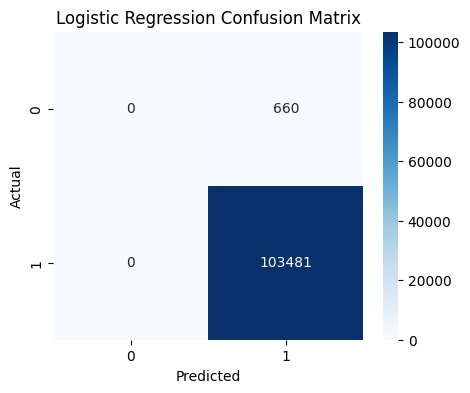

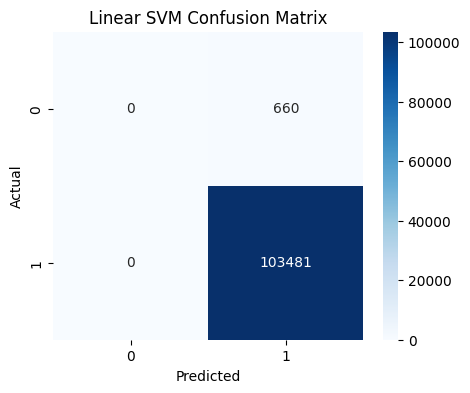

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load trained models (if not already in memory)
clf_log = joblib.load("/content/drive/MyDrive/email_project/sgd_logistic.joblib")
clf_svm = joblib.load("/content/drive/MyDrive/email_project/sgd_svm.joblib")

# Predict on test set
y_pred_log = clf_log.predict(X_test_tfidf)
y_pred_svm = clf_svm.predict(X_test_tfidf)

# Classification report
print("Logistic Regression (SGD) metrics:")
print(classification_report(y_test_arr, y_pred_log, digits=4))

print("Linear SVM (SGD) metrics:")
print(classification_report(y_test_arr, y_pred_svm, digits=4))

# Confusion matrix plotting function
def plot_cm(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_cm(y_test_arr, y_pred_log, "Logistic Regression Confusion Matrix")
plot_cm(y_test_arr, y_pred_svm, "Linear SVM Confusion Matrix")


1st evaluation done above

#    handle imbalance of dataset , undersample, oversample, use class weights properly

undersampling

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# df_all is your merged dataset
# Separate classes
df_corp = df_all[df_all['label'] == 1]  # corporate
df_noncorp = df_all[df_all['label'] == 0]  # non-corporate

print("Corporate emails:", len(df_corp))
print("Non-corporate emails:", len(df_noncorp))

# Undersample corporate emails to match non-corporate count
df_corp_sampled = df_corp.sample(n=len(df_noncorp), random_state=42)

# Combine undersampled corporate with all non-corporate emails
df_balanced = pd.concat([df_corp_sampled, df_noncorp]).sample(frac=1, random_state=42)  # shuffle

print("Balanced dataset shape:", df_balanced.shape)
print("Label distribution:\n", df_balanced['label'].value_counts())

# Split into train/test sets (e.g., 80-20)
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['clean_text'], df_balanced['label'], test_size=0.2, random_state=42, stratify=df_balanced['label']
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Corporate emails: 517401
Non-corporate emails: 3302
Balanced dataset shape: (6604, 2)
Label distribution:
 label
1    3302
0    3302
Name: count, dtype: int64
Train size: (5283,)
Test size: (1321,)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Load existing TF-IDF vectorizer or create a new one
tfidf_path = "/content/drive/MyDrive/email_project/tfidf_vectorizer.joblib"

try:
    vectorizer = joblib.load(tfidf_path)
    print("Loaded existing TF-IDF vectorizer.")
except:
    print("Creating a new TF-IDF vectorizer.")
    vectorizer = TfidfVectorizer(max_features=50000, stop_words='english')

# Fit on the training text and transform
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Save vectorizer
joblib.dump(vectorizer, tfidf_path)
print("Vectorizer saved to:", tfidf_path)

print("TF-IDF shapes -> X_train:", X_train_tfidf.shape, ", X_test:", X_test_tfidf.shape)


Loaded existing TF-IDF vectorizer.
Vectorizer saved to: /content/drive/MyDrive/email_project/tfidf_vectorizer.joblib
TF-IDF shapes -> X_train: (5283, 50000) , X_test: (1321, 50000)


In [ ]:
# 1️⃣ Split the balanced dataset into train/test again
from sklearn.model_selection import train_test_split

# Assuming df_balanced contains the balanced dataset
X_balanced = df_balanced['clean_text']
y_balanced = df_balanced['label']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.25, random_state=42, stratify=y_balanced
)

# 2️⃣ Vectorize using the TF-IDF saved for balanced dataset
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = joblib.load(tfidf_path)  # balanced TF-IDF

X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf  = tfidf_vectorizer.transform(X_test)

# 3️⃣ Convert y to numpy arrays
y_train_arr = np.array(y_train, dtype=np.int32)
y_test_arr  = np.array(y_test, dtype=np.int32)

print("Train size:", y_train_arr.shape)
print("Test size:", y_test_arr.shape)


Train size: (4953,)
Test size: (1651,)


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import time
import joblib
import numpy as np

# Paths to save models
balanced_model_dir = "/content/drive/MyDrive/email_project/balanced_models"
clf_log_path = balanced_model_dir + "/sgd_logistic_balanced.joblib"
clf_svm_path = balanced_model_dir + "/sgd_svm_balanced.joblib"
tfidf_path    = balanced_model_dir + "/tfidf_vectorizer_balanced.joblib"

# Compute class weights manually
classes = np.array([0, 1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_arr)
class_weight_dict = {0: weights[0], 1: weights[1]}
print("Manual class weights:", class_weight_dict)

# Initialize classifiers
clf_log = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1, tol=None,
                        random_state=42, class_weight=class_weight_dict)
clf_svm = SGDClassifier(loss='hinge', penalty='l2', max_iter=1, tol=None,
                        random_state=42, class_weight=class_weight_dict)

# Training in batches
batch_size = 2000
n_samples = X_train_tfidf.shape[0]
print("Training with n_samples:", n_samples, "batch_size:", batch_size)

start_time = time.time()
for start in range(0, n_samples, batch_size):
    end = min(start + batch_size, n_samples)
    X_batch = X_train_tfidf[start:end]
    y_batch = y_train_arr[start:end]
    if start == 0:
        clf_log.partial_fit(X_batch, y_batch, classes=classes)
        clf_svm.partial_fit(X_batch, y_batch, classes=classes)
    else:
        clf_log.partial_fit(X_batch, y_batch)
        clf_svm.partial_fit(X_batch, y_batch)
    print(f"Trained batches {start}..{end}  (total trained so far: {end}/{n_samples})")

print("Training finished. Elapsed:", round(time.time() - start_time, 1), "s")

# Save trained models
joblib.dump(clf_log, clf_log_path)
joblib.dump(clf_svm, clf_svm_path)
print("Saved models to:", clf_log_path, "and", clf_svm_path)

# Evaluate on test set
y_pred_log = clf_log.predict(X_test_tfidf)
y_pred_svm = clf_svm.predict(X_test_tfidf)

print("\nLogistic Regression (SGD) metrics:")
print(classification_report(y_test_arr, y_pred_log, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test_arr, y_pred_log))

print("\nLinear SVM (SGD) metrics:")
print(classification_report(y_test_arr, y_pred_svm, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test_arr, y_pred_svm))

print("Done.")


Manual class weights: {0: np.float64(1.0002019386106624), 1: np.float64(0.9997981429148163)}
Training with n_samples: 4953 batch_size: 2000
Trained batches 0..2000  (total trained so far: 2000/4953)
Trained batches 2000..4000  (total trained so far: 4000/4953)
Trained batches 4000..4953  (total trained so far: 4953/4953)
Training finished. Elapsed: 0.1 s
Saved models to: /content/drive/MyDrive/email_project/balanced_models/sgd_logistic_balanced.joblib and /content/drive/MyDrive/email_project/balanced_models/sgd_svm_balanced.joblib

Logistic Regression (SGD) metrics:
              precision    recall  f1-score   support

           0     0.9988    0.9964    0.9976       826
           1     0.9964    0.9988    0.9976       825

    accuracy                         0.9976      1651
   macro avg     0.9976    0.9976    0.9976      1651
weighted avg     0.9976    0.9976    0.9976      1651

Confusion matrix:
 [[823   3]
 [  1 824]]

Linear SVM (SGD) metrics:
              precision    reca

saving

In [ ]:
# Save merged & cleaned dataset
df_all.to_pickle("/content/drive/MyDrive/email_project/df_all.pkl")


In [ ]:
# Example paths
tfidf_path = "/content/drive/MyDrive/email_project/balanced_models/tfidf_vectorizer_balanced.joblib"
logistic_path = "/content/drive/MyDrive/email_project/balanced_models/sgd_logistic_balanced.joblib"
svm_path = "/content/drive/MyDrive/email_project/balanced_models/sgd_svm_balanced.joblib"


In [ ]:
import dill
# Save all variables
with open("/content/drive/MyDrive/email_project/session.pkl", "wb") as f:
    dill.dump_session(f)


# 23/09/2025 Resume



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import joblib
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier


In [ ]:
# Paths
base_path = "/content/drive/MyDrive/email_project/balanced_models/"

# Load vectorizer and models
vectorizer = joblib.load(base_path + "tfidf_vectorizer_balanced.joblib")
sgd_log = joblib.load(base_path + "sgd_logistic_balanced.joblib")
sgd_svm = joblib.load(base_path + "sgd_svm_balanced.joblib")


In [ ]:
# Inference pipeline

def classify_email(text, vectorizer, log_model, svm_model):
    # Transform text to TF-IDF features
    X = vectorizer.transform([text])

    # Predict with both models
    log_pred = log_model.predict(X)[0]
    svm_pred = svm_model.predict(X)[0]

    # Map labels back to names
    label_map = {0: "Non-Corporate", 1: "Corporate"}

    return {
        "Logistic_Regression": label_map[log_pred],
        "Linear_SVM": label_map[svm_pred]
    }

# Example usage
sample_email = "Dear team, please find attached the financial report for Q3."
results = classify_email(sample_email, vectorizer, sgd_log, sgd_svm)
print(results)


{'Logistic_Regression': 'Corporate', 'Linear_SVM': 'Corporate'}


# Building & testing inference pipeline


In [ ]:
import joblib

# Paths to saved files
base_path = "/content/drive/MyDrive/email_project/balanced_models/"

# Load vectorizer + models
vectorizer = joblib.load(base_path + "tfidf_vectorizer_balanced.joblib")
log_reg_model = joblib.load(base_path + "sgd_logistic_balanced.joblib")
svm_model = joblib.load(base_path + "sgd_svm_balanced.joblib")

print("Loaded vectorizer and models successfully!")


Loaded vectorizer and models successfully!


In [ ]:
def classify_email(text, model, vectorizer):
    """Classify a single email as Corporate (1) or Non-Corporate (0)."""
    X = vectorizer.transform([text])
    prediction = model.predict(X)[0]
    label = "Corporate" if prediction == 1 else "Non-Corporate"
    return label

def classify_batch(texts, model, vectorizer):
    """Classify a list of emails."""
    X = vectorizer.transform(texts)
    preds = model.predict(X)
    return ["Corporate" if p == 1 else "Non-Corporate" for p in preds]


In [ ]:
sample_emails = [
    "Meeting scheduled with the HR team tomorrow at 10 AM.",
    "Hey bro, let’s catch up for cricket this weekend!"
]

print("Logistic Regression Predictions:")
for email in sample_emails:
    print(email, "->", classify_email(email, log_reg_model, vectorizer))

print("\nSVM Predictions:")
for email in sample_emails:
    print(email, "->", classify_email(email, svm_model, vectorizer))


Logistic Regression Predictions:
Meeting scheduled with the HR team tomorrow at 10 AM. -> Corporate
Hey bro, let’s catch up for cricket this weekend! -> Corporate

SVM Predictions:
Meeting scheduled with the HR team tomorrow at 10 AM. -> Corporate
Hey bro, let’s catch up for cricket this weekend! -> Corporate


clean evaluation block

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, joblib, pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

project_path = "/content/drive/MyDrive/email_project"
balanced_dir = os.path.join(project_path, "balanced_models")
os.makedirs(balanced_dir, exist_ok=True)

print("project_path:", project_path)
print("balanced_dir:", balanced_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
project_path: /content/drive/MyDrive/email_project
balanced_dir: /content/drive/MyDrive/email_project/balanced_models


In [ ]:
df_all_path = os.path.join(project_path, "df_all.pkl")

if os.path.exists(df_all_path):
    df_all = pd.read_pickle(df_all_path)
    print("Loaded df_all from:", df_all_path, "shape:", df_all.shape)
else:
    raise FileNotFoundError(f"{df_all_path} not found. If you did not save df_all earlier, load df_enron and df_spamass and rebuild df_all first.")


Loaded df_all from: /content/drive/MyDrive/email_project/df_all.pkl shape: (520703, 2)


In [ ]:
# Identify which column contains cleaned text
if 'clean_text' in df_all.columns:
    text_col = 'clean_text'
elif 'text' in df_all.columns:
    text_col = 'text'
elif 'message' in df_all.columns:
    text_col = 'message'
else:
    raise KeyError("No text column found in df_all. Columns: " + str(df_all.columns.tolist()))

df_noncorp = df_all[df_all['label'] == 0]
df_corp   = df_all[df_all['label'] == 1]

print("Counts before sampling -> corporate:", len(df_corp), " non-corp:", len(df_noncorp))

# Undersample corporate to match non-corp (same approach as before)
df_corp_sampled = df_corp.sample(n=len(df_noncorp), random_state=42)
df_balanced = pd.concat([df_corp_sampled, df_noncorp], ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset shape:", df_balanced.shape)
print("Label distribution:\n", df_balanced['label'].value_counts())


Counts before sampling -> corporate: 517401  non-corp: 3302
Balanced dataset shape: (6604, 2)
Label distribution:
 label
1    3302
0    3302
Name: count, dtype: int64


In [ ]:
X = df_balanced[text_col]
y = df_balanced['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())


X_train: (4953,) X_test: (1651,)
y_train distribution:
 label
1    2477
0    2476
Name: count, dtype: int64
y_test distribution:
 label
0    826
1    825
Name: count, dtype: int64


In [ ]:
tfidf_path = os.path.join(balanced_dir, "tfidf_vectorizer_balanced.joblib")

if os.path.exists(tfidf_path):
    vectorizer = joblib.load(tfidf_path)
    print("Loaded TF-IDF vectorizer from:", tfidf_path)
else:
    print("No saved balanced TF-IDF found. Fitting new vectorizer (this may take a moment).")
    vectorizer = TfidfVectorizer(max_features=50000, stop_words='english')
    vectorizer.fit(X_train)
    joblib.dump(vectorizer, tfidf_path)
    print("Saved new vectorizer to:", tfidf_path)

# Transform (important: predictions must use vectorized data)
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("TF-IDF shapes -> X_train:", X_train_tfidf.shape, ", X_test:", X_test_tfidf.shape)


Loaded TF-IDF vectorizer from: /content/drive/MyDrive/email_project/balanced_models/tfidf_vectorizer_balanced.joblib
TF-IDF shapes -> X_train: (4953, 50000) , X_test: (1651, 50000)


Loaded models: /content/drive/MyDrive/email_project/balanced_models/sgd_logistic_balanced.joblib /content/drive/MyDrive/email_project/balanced_models/sgd_svm_balanced.joblib
📊 Logistic Regression (SGD) Report
               precision    recall  f1-score   support

Non-Corporate       1.00      1.00      1.00       826
    Corporate       1.00      1.00      1.00       825

     accuracy                           1.00      1651
    macro avg       1.00      1.00      1.00      1651
 weighted avg       1.00      1.00      1.00      1651

Accuracy: 0.9975772259236826


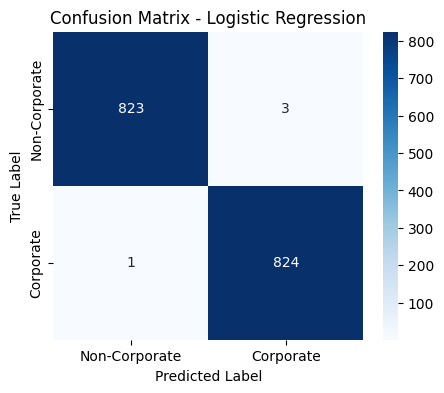


📊 Linear SVM (SGD) Report
               precision    recall  f1-score   support

Non-Corporate       1.00      1.00      1.00       826
    Corporate       1.00      1.00      1.00       825

     accuracy                           1.00      1651
    macro avg       1.00      1.00      1.00      1651
 weighted avg       1.00      1.00      1.00      1651

Accuracy: 0.9981829194427619


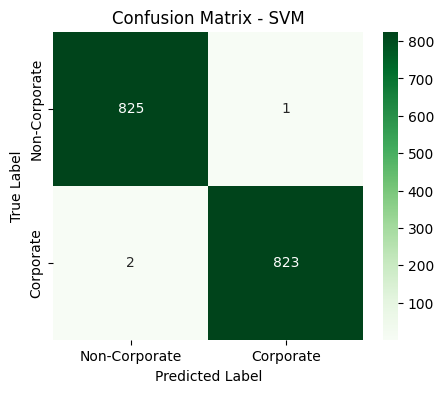

In [ ]:
# Paths for models
log_path = os.path.join(balanced_dir, "sgd_logistic_balanced.joblib")
svm_path = os.path.join(balanced_dir, "sgd_svm_balanced.joblib")

# Load models (will raise if missing)
log_reg_model = joblib.load(log_path)
svm_model     = joblib.load(svm_path)
print("Loaded models:", log_path, svm_path)

# Predict on vectorized test set
y_pred_log = log_reg_model.predict(X_test_tfidf)
y_pred_svm = svm_model.predict(X_test_tfidf)

# Reports
print("📊 Logistic Regression (SGD) Report")
print(classification_report(y_test, y_pred_log, target_names=["Non-Corporate", "Corporate"]))
print("Accuracy:", accuracy_score(y_test, y_pred_log))

cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(5,4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Corporate", "Corporate"],
            yticklabels=["Non-Corporate", "Corporate"])
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print("\n📊 Linear SVM (SGD) Report")
print(classification_report(y_test, y_pred_svm, target_names=["Non-Corporate", "Corporate"]))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Non-Corporate", "Corporate"],
            yticklabels=["Non-Corporate", "Corporate"])
plt.title("Confusion Matrix - SVM")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [ ]:
balanced_dataset_path = os.path.join(project_path, "df_balanced.pkl")
df_balanced.to_pickle(balanced_dataset_path)
print("Balanced dataset saved to:", balanced_dataset_path)


Balanced dataset saved to: /content/drive/MyDrive/email_project/df_balanced.pkl


In [ ]:
train_test_path = os.path.join(project_path, "train_test_splits.pkl")
joblib.dump({
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}, train_test_path)
print("Train/test splits saved to:", train_test_path)


Train/test splits saved to: /content/drive/MyDrive/email_project/train_test_splits.pkl


In [ ]:
vectorizer_path = os.path.join(balanced_dir, "tfidf_vectorizer_balanced.joblib")
joblib.dump(vectorizer, vectorizer_path)
print("TF-IDF vectorizer saved to:", vectorizer_path)


TF-IDF vectorizer saved to: /content/drive/MyDrive/email_project/balanced_models/tfidf_vectorizer_balanced.joblib


In [ ]:
log_model_path = os.path.join(balanced_dir, "sgd_logistic_balanced.joblib")
svm_model_path = os.path.join(balanced_dir, "sgd_svm_balanced.joblib")
joblib.dump(log_reg_model, log_model_path)
joblib.dump(svm_model, svm_model_path)
print("Models saved to:", log_model_path, "and", svm_model_path)


Models saved to: /content/drive/MyDrive/email_project/balanced_models/sgd_logistic_balanced.joblib and /content/drive/MyDrive/email_project/balanced_models/sgd_svm_balanced.joblib


Resuming dec 2025


In [ ]:
import pandas as pd
import os

project_path = "/content/drive/MyDrive/email_project"
df_all_path = os.path.join(project_path, "df_all.pkl")

if os.path.exists(df_all_path):
    df_all = pd.read_pickle(df_all_path)
    print("Loaded df_all! Shape:", df_all.shape)
else:
    print("df_all.pkl NOT FOUND. We need to recreate df_all before proceeding.")


Loaded df_all! Shape: (520703, 2)


In [ ]:
df_all.columns


Index(['clean_text', 'label'], dtype='object')

In [ ]:
# CELL 1: imports, paths, helper functions
from pathlib import Path
import os, time, joblib, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
project_path = "/content/drive/MyDrive/email_project"
models_dir = os.path.join(project_path, "models_comparison")
os.makedirs(models_dir, exist_ok=True)

# Small helpers
def fit_vectorizer(X_train, max_features=50000):
    vec = TfidfVectorizer(max_features=max_features, stop_words='english')
    vec.fit(X_train)
    return vec

def batch_partial_fit(clf, X_tfidf, y_arr, classes, batch_size=20000):
    n = X_tfidf.shape[0]
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        Xb = X_tfidf[start:end]
        yb = y_arr[start:end]
        if start == 0:
            clf.partial_fit(Xb, yb, classes=classes)
        else:
            clf.partial_fit(Xb, yb)

def evaluate_preds(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0,1], zero_division=0)
    # p,r,f are arrays for labels [0,1]
    return {
        "accuracy": acc,
        "precision_0": p[0], "recall_0": r[0], "f1_0": f[0],
        "precision_1": p[1], "recall_1": r[1], "f1_1": f[1]
    }

def plot_cm(cm, title, labels=["Non-Corporate","Corporate"], cmap="Blues"):
    plt.figure(figsize=(4.5,3.5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(title)
    plt.show()


In [ ]:
# CELL 2: load df_all
df_all_path = os.path.join(project_path, "df_all.pkl")
if not os.path.exists(df_all_path):
    raise FileNotFoundError(f"{df_all_path} not found. Save df_all before running this cell.")
df_all = pd.read_pickle(df_all_path)
print("Loaded df_all shape:", df_all.shape)
print(df_all.columns)
print("Label counts:\n", df_all['label'].value_counts())


Loaded df_all shape: (520703, 2)
Index(['clean_text', 'label'], dtype='object')
Label counts:
 label
1    517401
0      3302
Name: count, dtype: int64


In [ ]:
# CELL 3: run 3 scenarios and save results
results = []

# General settings (tweak if you get memory issues)
MAX_FEATURES = 30000   # reduce from 50000 if colab RAM issues
BIG_BATCH = 20000      # for large dataset
SMALL_BATCH = 2000     # for smaller datasets

# Common helper for training & evaluating one scenario
def run_scenario(name, X, y, use_class_weight=False, undersample=False):
    print("\n" + "="*60)
    print("RUNNING:", name)
    print("Total rows:", len(X))
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=42, stratify=y)
    # Fit a fresh vectorizer per scenario to keep experiments independent
    vec = fit_vectorizer(X_train, max_features=MAX_FEATURES)
    X_train_tfidf = vec.transform(X_train)
    X_test_tfidf  = vec.transform(X_test)

    # compute class weights dict if requested
    classes = np.array([0,1])
    class_weight_dict = None
    if use_class_weight:
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
        class_weight_dict = {0: float(weights[0]), 1: float(weights[1])}
        print("Using manual class weights:", class_weight_dict)

    # init classifiers
    clf_log = SGDClassifier(loss='log_loss', penalty='l2', random_state=42,
                            class_weight=class_weight_dict)
    clf_svm = SGDClassifier(loss='hinge', penalty='l2', random_state=42,
                            class_weight=class_weight_dict)

    # choose batch size
    batch_size = SMALL_BATCH if X_train_tfidf.shape[0] < 20000 else BIG_BATCH

    # batch train
    t0 = time.time()
    batch_partial_fit(clf_log, X_train_tfidf, np.array(y_train), classes, batch_size=batch_size)
    batch_partial_fit(clf_svm, X_train_tfidf, np.array(y_train), classes, batch_size=batch_size)
    elapsed = time.time() - t0
    print("Training time (s):", round(elapsed,2))

    # preds and eval
    y_pred_log = clf_log.predict(X_test_tfidf)
    y_pred_svm = clf_svm.predict(X_test_tfidf)
    metrics_log = evaluate_preds(y_test, y_pred_log)
    metrics_svm = evaluate_preds(y_test, y_pred_svm)

    # confusion matrices
    cm_log = confusion_matrix(y_test, y_pred_log, labels=[0,1])
    cm_svm = confusion_matrix(y_test, y_pred_svm, labels=[0,1])

    # save models & vectorizer
    prefix = name.replace(" ","_").lower()
    vec_path = os.path.join(models_dir, f"{prefix}_tfidf.joblib")
    log_path = os.path.join(models_dir, f"{prefix}_sgd_log.joblib")
    svm_path = os.path.join(models_dir, f"{prefix}_sgd_svm.joblib")
    joblib.dump(vec, vec_path)
    joblib.dump(clf_log, log_path)
    joblib.dump(clf_svm, svm_path)
    print("Saved artifacts:", vec_path, log_path, svm_path)

    # return results
    return {
        "scenario": name,
        "n_train": X_train_tfidf.shape[0],
        "n_test": X_test_tfidf.shape[0],
        "metrics_log": metrics_log,
        "metrics_svm": metrics_svm,
        "cm_log": cm_log,
        "cm_svm": cm_svm,
        "vec_path": vec_path,
        "log_path": log_path,
        "svm_path": svm_path
    }

# ------------- Scenario 1: ORIGINAL (imbalanced) -------------
X_all = df_all['clean_text']
y_all = df_all['label']
res1 = run_scenario("original_imbalanced", X_all, y_all, use_class_weight=False)
results.append(res1)

# ------------- Scenario 2: BALANCED (undersample corporate) -------------
# create balanced DF (undersample corporate)
df_noncorp = df_all[df_all['label']==0]
df_corp = df_all[df_all['label']==1]
df_corp_sampled = df_corp.sample(n=len(df_noncorp), random_state=42)
df_bal = pd.concat([df_noncorp, df_corp_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
res2 = run_scenario("balanced_undersample", df_bal['clean_text'], df_bal['label'], use_class_weight=False)
results.append(res2)

# ------------- Scenario 3: IMBALANCED + CLASS_WEIGHTS -------------
res3 = run_scenario("imbalanced_with_class_weights", X_all, y_all, use_class_weight=True)
results.append(res3)

# Save summary
summary_rows = []
for r in results:
    # log metrics and svm metrics
    ml = r["metrics_log"]
    ms = r["metrics_svm"]
    summary_rows.append({
        "scenario": r["scenario"],
        "model": "Logistic_SGD",
        "n_train": r["n_train"],
        "n_test": r["n_test"],
        "accuracy": ml["accuracy"],
        "precision_noncorp": ml["precision_0"],
        "recall_noncorp": ml["recall_0"],
        "f1_noncorp": ml["f1_0"],
        "precision_corp": ml["precision_1"],
        "recall_corp": ml["recall_1"],
        "f1_corp": ml["f1_1"]
    })
    summary_rows.append({
        "scenario": r["scenario"],
        "model": "SVM_SGD",
        "n_train": r["n_train"],
        "n_test": r["n_test"],
        "accuracy": ms["accuracy"],
        "precision_noncorp": ms["precision_0"],
        "recall_noncorp": ms["recall_0"],
        "f1_noncorp": ms["f1_0"],
        "precision_corp": ms["precision_1"],
        "recall_corp": ms["recall_1"],
        "f1_corp": ms["f1_1"]
    })

summary_df = pd.DataFrame(summary_rows)
summary_csv = os.path.join(models_dir, "comparison_summary.csv")
summary_df.to_csv(summary_csv, index=False)
print("\nSaved comparison summary to:", summary_csv)
print(summary_df)



RUNNING: original_imbalanced
Total rows: 520703
Training time (s): 2.44
Saved artifacts: /content/drive/MyDrive/email_project/models_comparison/original_imbalanced_tfidf.joblib /content/drive/MyDrive/email_project/models_comparison/original_imbalanced_sgd_log.joblib /content/drive/MyDrive/email_project/models_comparison/original_imbalanced_sgd_svm.joblib

RUNNING: balanced_undersample
Total rows: 6604
Training time (s): 0.07
Saved artifacts: /content/drive/MyDrive/email_project/models_comparison/balanced_undersample_tfidf.joblib /content/drive/MyDrive/email_project/models_comparison/balanced_undersample_sgd_log.joblib /content/drive/MyDrive/email_project/models_comparison/balanced_undersample_sgd_svm.joblib

RUNNING: imbalanced_with_class_weights
Total rows: 520703
Using manual class weights: {0: 78.83459500378501, 1: 0.5031914379590259}
Training time (s): 3.2
Saved artifacts: /content/drive/MyDrive/email_project/models_comparison/imbalanced_with_class_weights_tfidf.joblib /content/dr

,scenario,model,n_train,n_test,accuracy,precision_noncorp,recall_noncorp,f1_noncorp,precision_corp,recall_corp,f1_corp
0,original_imbalanced,Logistic_SGD,416562,104141,0.997974,1.000000,0.680303,0.809739,0.997965,1.000000,0.998982
1,original_imbalanced,SVM_SGD,416562,104141,0.998886,1.000000,0.824242,0.903654,0.998880,1.000000,0.999440
2,balanced_undersample,Logistic_SGD,5283,1321,0.998486,0.996983,1.000000,0.998489,1.000000,0.996970,0.998483
3,balanced_undersample,SVM_SGD,5283,1321,0.996972,0.993985,1.000000,0.996983,1.000000,0.993939,0.996960
4,imbalanced_with_class_weights,Logistic_SGD,416562,104141,0.996217,0.626667,0.996970,0.769591,0.999981,0.996212,0.998093
5,imbalanced_with_class_weights,SVM_SGD,416562,104141,0.995948,0.609982,1.000000,0.757750,1.000000,0.995922,0.997957



SCENARIO: original_imbalanced
Logistic Confusion Matrix:


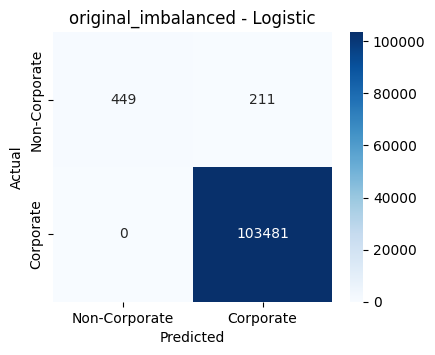

SVM Confusion Matrix:


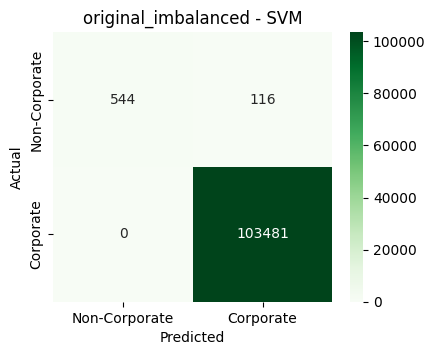


SCENARIO: balanced_undersample
Logistic Confusion Matrix:


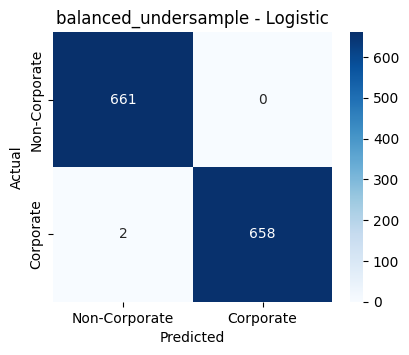

SVM Confusion Matrix:


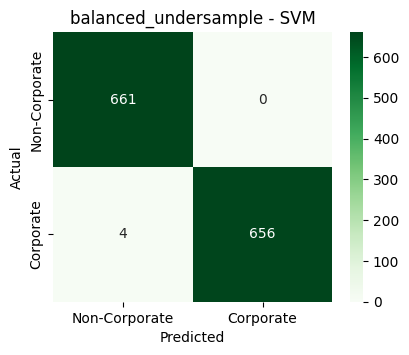


SCENARIO: imbalanced_with_class_weights
Logistic Confusion Matrix:


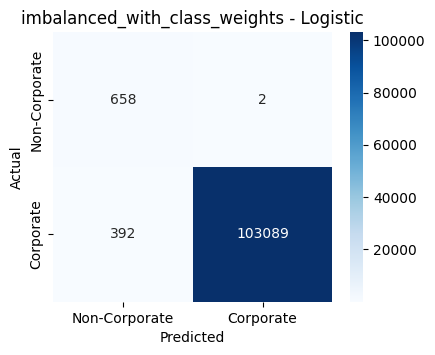

SVM Confusion Matrix:


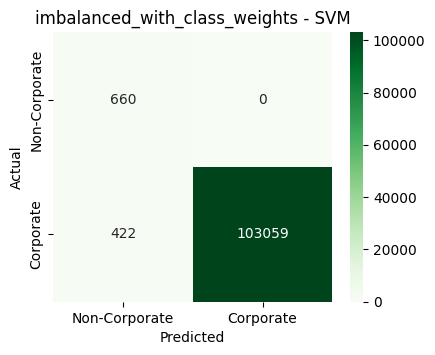

In [ ]:
# CELL 4: Visualize confusion matrices and pretty table from results (uses 'results' object from CELL 3)
import pandas as pd

# load the summary CSV
summary = pd.read_csv(os.path.join(models_dir, "comparison_summary.csv"))
display(summary)

# Plot confusion matrices for each scenario (logistic & svm)
for r in results:
    print("\nSCENARIO:", r['scenario'])
    print("Logistic Confusion Matrix:")
    plot_cm(r['cm_log'], title=f"{r['scenario']} - Logistic", cmap="Blues")
    print("SVM Confusion Matrix:")
    plot_cm(r['cm_svm'], title=f"{r['scenario']} - SVM", cmap="Greens")


resume Jan 2025


In [ ]:
import joblib
import os

project_path = "/content/drive/MyDrive/email_project"
balanced_dir = os.path.join(project_path, "models_comparison")

# Balanced undersample model files
vectorizer_path = os.path.join(balanced_dir, "balanced_undersample_tfidf.joblib")
log_model_path = os.path.join(balanced_dir, "balanced_undersample_sgd_log.joblib")
svm_model_path = os.path.join(balanced_dir, "balanced_undersample_sgd_svm.joblib")

# Load vectorizer and models
vectorizer = joblib.load(vectorizer_path)
log_model = joblib.load(log_model_path)
svm_model = joblib.load(svm_model_path)

print("Loaded balanced undersample models successfully!")


Loaded balanced undersample models successfully!


In [ ]:
def predict_email_category(text, model, vectorizer):
    X = vectorizer.transform([text])
    pred = model.predict(X)[0]
    return "Corporate" if pred == 1 else "Non-Corporate"


In [ ]:
test_emails = [
    "Reminder: The finance team meeting is scheduled for 3 PM tomorrow.",
    "Hey bro, wanna play football this weekend?",
    "Please review the attached PDF and send me the updated proposal.",
    "Congratulations! You have won a lucky draw, click here to claim your reward!",
    "Mom said dinner is ready. Come downstairs!"
]

print("---- Logistic Regression (Balanced) ----")
for email in test_emails:
    print(email, "→", predict_email_category(email, log_model, vectorizer))

print("\n---- SVM (Balanced) ----")
for email in test_emails:
    print(email, "→", predict_email_category(email, svm_model, vectorizer))


---- Logistic Regression (Balanced) ----
Reminder: The finance team meeting is scheduled for 3 PM tomorrow. → Corporate
Hey bro, wanna play football this weekend? → Corporate
Please review the attached PDF and send me the updated proposal. → Corporate
Congratulations! You have won a lucky draw, click here to claim your reward! → Corporate
Mom said dinner is ready. Come downstairs! → Corporate

---- SVM (Balanced) ----
Reminder: The finance team meeting is scheduled for 3 PM tomorrow. → Corporate
Hey bro, wanna play football this weekend? → Corporate
Please review the attached PDF and send me the updated proposal. → Corporate
Congratulations! You have won a lucky draw, click here to claim your reward! → Corporate
Mom said dinner is ready. Come downstairs! → Corporate


In [ ]:
print("Vectorizer path:", vectorizer_path)
print("Logistic path :", log_model_path)
print("SVM path      :", svm_model_path)


Vectorizer path: /content/drive/MyDrive/email_project/models_comparison/balanced_undersample_tfidf.joblib
Logistic path : /content/drive/MyDrive/email_project/models_comparison/balanced_undersample_sgd_log.joblib
SVM path      : /content/drive/MyDrive/email_project/models_comparison/balanced_undersample_sgd_svm.joblib


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [ ]:
# Load df_balanced again for consistency
balanced_df = pd.read_pickle("/content/drive/MyDrive/email_project/df_balanced.pkl")

X = balanced_df['clean_text']
y = balanced_df['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

X_test_tfidf = vectorizer.transform(X_test)

y_pred_log = log_model.predict(X_test_tfidf)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_log))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       826
           1       1.00      1.00      1.00       825

    accuracy                           1.00      1651
   macro avg       1.00      1.00      1.00      1651
weighted avg       1.00      1.00      1.00      1651


Confusion Matrix:
 [[826   0]
 [  1 824]]


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_email_text(text):
    text = str(text).lower()

    # Remove headers (lines like "X-Mailer", "From:", etc.)
    text = re.sub(r'\S+@\S+', ' ', text)          # remove emails
    text = re.sub(r'http\S+', ' ', text)          # remove URLs
    text = re.sub(r'\d+', ' ', text)              # remove numbers
    text = re.sub(r'[^a-z\s]', ' ', text)         # remove non-letters
    text = re.sub(r'\s+', ' ', text).strip()      # trim whitespace

    # Remove stopwords
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def predict_email_category(text, model, vectorizer):
    cleaned = clean_email_text(text)
    X = vectorizer.transform([cleaned])
    pred = model.predict(X)[0]
    return "Corporate" if pred == 1 else "Non-Corporate"


In [ ]:
test_emails = [
    "Reminder: The finance team meeting is scheduled for 3 PM tomorrow.",
    "Hey bro, wanna play football this weekend?",
    "Please review the attached PDF and send me the updated proposal.",
    "Congratulations! You have won a lucky draw, click here to claim your reward!",
    "Mom said dinner is ready. Come downstairs!"
]

for email in test_emails:
    print(email, "→", predict_email_category(email, log_model, vectorizer))


Reminder: The finance team meeting is scheduled for 3 PM tomorrow. → Corporate
Hey bro, wanna play football this weekend? → Corporate
Please review the attached PDF and send me the updated proposal. → Corporate
Congratulations! You have won a lucky draw, click here to claim your reward! → Corporate
Mom said dinner is ready. Come downstairs! → Corporate


In [ ]:
print("Vocabulary size:", len(vectorizer.vocabulary_))

sample_words = ["bro", "mom", "lucky", "football", "meeting", "proposal"]
for w in sample_words:
    print(w, "→", w in vectorizer.vocabulary_)


Vocabulary size: 30000
bro → False
mom → True
lucky → True
football → True
meeting → True
proposal → True


In [ ]:
cleaned_test = clean_email_text("Hey bro wanna play football this weekend?")
print("Cleaned:", cleaned_test)
print("Vector sum:", vectorizer.transform([cleaned_test]).sum())


Cleaned: hey bro wanna play football weekend
Vector sum: 2.200825667622394


In [ ]:
noncorp_examples = [
    "hey bro how was your day",
    "mom said dinner is ready come downstairs",
    "wanna play football this weekend",
    "are you free tonight let's watch a movie",
    "can we go shopping tomorrow",
    "good morning hope you slept well",
    "happy birthday wish you all the best",
    "call me when you reach home",
    "send me the photos from yesterday",
    "lets go out for lunch today",
]

import pandas as pd

synthetic_df = pd.DataFrame({
    "clean_text": noncorp_examples * 300,   # 10 × 300 = 3000 samples
    "label": 0
})

synthetic_df.shape


(3000, 2)

In [ ]:
enhanced_df = pd.concat([balanced_df, synthetic_df], ignore_index=True)

print("New dataset shape:", enhanced_df.shape)
print(enhanced_df['label'].value_counts())


New dataset shape: (9604, 2)
label
0    6302
1    3302
Name: count, dtype: int64


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import os

# Create final directory
final_dir = "/content/drive/MyDrive/email_project/final_classifier"
os.makedirs(final_dir, exist_ok=True)

# TF-IDF vectorizer
vectorizer_final = TfidfVectorizer(
    max_features=30000,
    stop_words="english"
)

X_final = enhanced_df["clean_text"]
y_final = enhanced_df["label"]

X_final_tfidf = vectorizer_final.fit_transform(X_final)

# Save vectorizer
tfidf_path = os.path.join(final_dir, "tfidf_final.joblib")
joblib.dump(vectorizer_final, tfidf_path)

print("Final TF-IDF vectorizer saved:", tfidf_path)
print("TF-IDF shape:", X_final_tfidf.shape)


Final TF-IDF vectorizer saved: /content/drive/MyDrive/email_project/final_classifier/tfidf_final.joblib
TF-IDF shape: (9604, 30000)


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split final dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_final_tfidf, y_final, test_size=0.25, random_state=42, stratify=y_final
)

# Logistic Regression
log_final = SGDClassifier(loss="log_loss", random_state=42)
log_final.fit(X_train, y_train)

# SVM
svm_final = SGDClassifier(loss="hinge", random_state=42)
svm_final.fit(X_train, y_train)

# Save models
log_path = os.path.join(final_dir, "logistic_final.joblib")
svm_path = os.path.join(final_dir, "svm_final.joblib")

joblib.dump(log_final, log_path)
joblib.dump(svm_final, svm_path)

print("Final models saved:")
print("Logistic →", log_path)
print("SVM      →", svm_path)


Final models saved:
Logistic → /content/drive/MyDrive/email_project/final_classifier/logistic_final.joblib
SVM      → /content/drive/MyDrive/email_project/final_classifier/svm_final.joblib


In [ ]:
print("---- Logistic Final ----")
y_pred_log = log_final.predict(X_test)
print(classification_report(y_test, y_pred_log, target_names=["Non-Corporate", "Corporate"]))
print(confusion_matrix(y_test, y_pred_log))

print("\n---- SVM Final ----")
y_pred_svm = svm_final.predict(X_test)
print(classification_report(y_test, y_pred_svm, target_names=["Non-Corporate", "Corporate"]))
print(confusion_matrix(y_test, y_pred_svm))


---- Logistic Final ----
               precision    recall  f1-score   support

Non-Corporate       1.00      1.00      1.00      1576
    Corporate       1.00      1.00      1.00       825

     accuracy                           1.00      2401
    macro avg       1.00      1.00      1.00      2401
 weighted avg       1.00      1.00      1.00      2401

[[1576    0]
 [   1  824]]

---- SVM Final ----
               precision    recall  f1-score   support

Non-Corporate       1.00      1.00      1.00      1576
    Corporate       1.00      1.00      1.00       825

     accuracy                           1.00      2401
    macro avg       1.00      1.00      1.00      2401
 weighted avg       1.00      1.00      1.00      2401

[[1574    2]
 [   3  822]]


In [ ]:
def predict_email_category_final(text, model, vectorizer):
    cleaned = clean_email_text(text)
    X = vectorizer.transform([cleaned])
    pred = model.predict(X)[0]
    return "Corporate" if pred == 1 else "Non-Corporate"


In [ ]:
print(predict_email_category_final("Hey bro wanna play football this weekend?", log_final, vectorizer_final))
print(predict_email_category_final("Mom said dinner is ready", log_final, vectorizer_final))
print(predict_email_category_final("Please review the attached proposal", log_final, vectorizer_final))
print(predict_email_category_final("Lucky draw reward claim now", log_final, vectorizer_final))


Non-Corporate
Non-Corporate
Corporate
Corporate


final classifier pipeline

In [ ]:
import joblib

project_path = "/content/drive/MyDrive/email_project/final_classifier"

vectorizer_final = joblib.load(f"{project_path}/tfidf_final.joblib")
model_final = joblib.load(f"{project_path}/logistic_final.joblib")

print("Final classifier loaded!")


Final classifier loaded!


In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def clean_email_text(text):
    text = str(text).lower()
    text = re.sub(r'\S+@\S+', ' ', text)     # remove emails
    text = re.sub(r'http\S+', ' ', text)     # remove URLs
    text = re.sub(r'\d+', ' ', text)         # remove numbers
    text = re.sub(r'[^a-z\s]', ' ', text)    # remove non-letters
    text = re.sub(r'\s+', ' ', text).strip()
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)


In [ ]:
def classify_email(text):
    cleaned = clean_email_text(text)
    vectorized = vectorizer_final.transform([cleaned])
    pred = model_final.predict(vectorized)[0]
    return "Corporate" if pred == 1 else "Non-Corporate"


In [ ]:
samples = [
    "Hey bro wanna play football this weekend?",
    "Please review the attached proposal and send updates.",
    "Mom said dinner is ready",
    "Your meeting with finance team is at 3 PM",
    "Congratulations you won a free reward click here"
]

for s in samples:
    print(s, "→", classify_email(s))


Hey bro wanna play football this weekend? → Non-Corporate
Please review the attached proposal and send updates. → Corporate
Mom said dinner is ready → Non-Corporate
Your meeting with finance team is at 3 PM → Corporate
Congratulations you won a free reward click here → Non-Corporate


In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/email_project/final_classifier/tfidf_final.joblib")
files.download("/content/drive/MyDrive/email_project/final_classifier/logistic_final.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>